In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import LSTM

In [20]:
df = pd.read_csv("../Data/preprocessed/fakenews_preprocessed.csv")

In [42]:
def evaluate_model(model_name, y_true, y_pred):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

In [43]:
results = []

In [21]:
X = df["prep_text"].astype(str).values
X

array(['donald trump wish american happ new ear leave instead give shout enemy hater ver dishonest fake news medium former realit show star one job countr rapidl grows stronger smarter want wish friend supporter enemy hater even ver dishonest fake news medium happ health new ear president angr pant tweeted great ear america countr rapidl grows stronger smarter want wish friend supporter enemy hater even ver dishonest fake news medium happ health new ear great ear america donald j trump realdonaldtrump december trump tweet went welll ou expectwhat kind president sends new ear greeting like despicable pett infantile gibberish onl trump lack decenc even allow rise gutter long enough wish american citi en happ new ear bishop talbert swan talbertswan december one like ou calvin calvinstowell december impeachment would make great ear america also accept regaining control congress miranda aver miranda aver december ou hear ourself talk ou include man people hate ou ou wonder wh hate alan sand

In [22]:
y = df["real"].values

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
max_vocab_size = 50000
max_len = 200
embedding_dim = 64

In [25]:
text_vec = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode="int",
    output_sequence_length=max_len,
    standardize="lower_and_strip_punctuation",
    split="whitespace"
)


In [26]:
text_vec.adapt(X_train)

In [27]:
inputs = tf.keras.Input(shape=(), dtype=tf.string)

# Build Simple RNN architecture

In [28]:
x = text_vec(inputs)
x = layers.Embedding(input_dim=max_vocab_size, output_dim=embedding_dim)(x)
x = layers.SimpleRNN(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

In [29]:
model_rnn = models.Model(inputs, outputs)
model_rnn.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [30]:
history_rnn = model_rnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=128,
    shuffle=True
)

Epoch 1/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.7782 - loss: 0.4842 - val_accuracy: 0.5883 - val_loss: 0.6171
Epoch 2/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.7029 - loss: 0.5794 - val_accuracy: 0.7608 - val_loss: 0.4693
Epoch 3/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.7422 - loss: 0.4965 - val_accuracy: 0.7061 - val_loss: 0.5684


In [31]:
y_pred_prob_rnn = model_rnn.predict(X_val)
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int).flatten()

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [32]:
model_rnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 64)        │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,624,965 (36.72 MB)

 Trainable params: 3,208,321 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,416,644 (24.48 MB)

In [35]:
print(history_rnn.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


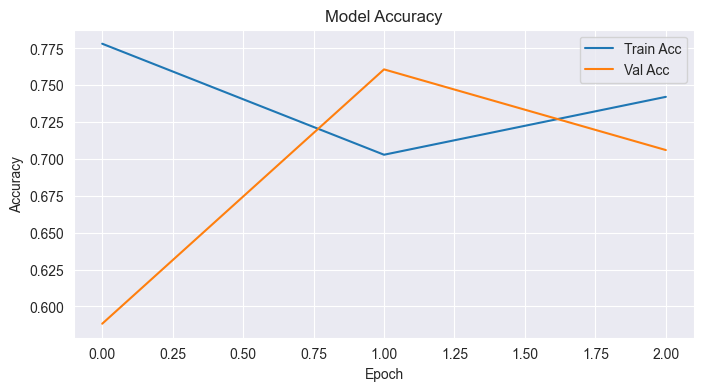

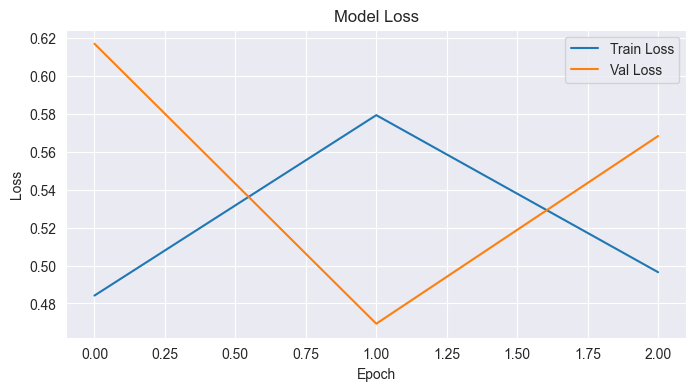

In [37]:
plt.figure(figsize=(8,4))
plt.plot(history_rnn.history['accuracy'], label='Train Acc')
plt.plot(history_rnn.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [38]:
loss, acc = model_rnn.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {acc:.4f}")
print(f"Validation loss: {loss:.4f}")

Validation accuracy: 0.7061
Validation loss: 0.5684


In [40]:
print(classification_report(y_val, y_pred_rnn))
print(confusion_matrix(y_val, y_pred_rnn))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61      5302
           1       0.71      0.83      0.76      7124

    accuracy                           0.71     12426
   macro avg       0.71      0.68      0.69     12426
weighted avg       0.71      0.71      0.70     12426

[[2867 2435]
 [1217 5907]]


In [45]:
metrics_rnn = evaluate_model("Simple RNN", y_val, y_pred_rnn)
metrics_rnn

{'Model': 'Simple RNN',
 'Accuracy': 0.7061001126669886,
 'Precision': 0.7081035722848238,
 'Recall': 0.8291690061763054,
 'F1': 0.7638691322901849}

In [46]:
results.append(metrics_rnn)

# LSTM

In [47]:
X_train_pad = text_vec(X_train)
X_val_pad = text_vec(X_val)

In [48]:
model_lstm = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim),
    LSTM(64),
    Dense(1, activation="sigmoid")
])

In [49]:
model_lstm.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

In [50]:
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=3,
    batch_size=128,
    verbose=1
)

Epoch 1/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.8964 - loss: 0.2817 - val_accuracy: 0.9485 - val_loss: 0.1990
Epoch 2/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.9582 - loss: 0.1704 - val_accuracy: 0.9491 - val_loss: 0.1950
Epoch 3/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.9578 - loss: 0.1563 - val_accuracy: 0.9520 - val_loss: 0.1857


In [51]:
y_proba_lstm = model_lstm.predict(X_val_pad)
y_pred_lstm = (y_proba_lstm >= 0.5).astype(int).flatten()

389/389 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


In [52]:
print(classification_report(y_val, y_pred_lstm))
print(confusion_matrix(y_val, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      5302
           1       0.95      0.97      0.96      7124

    accuracy                           0.95     12426
   macro avg       0.95      0.95      0.95     12426
weighted avg       0.95      0.95      0.95     12426

[[4917  385]
 [ 211 6913]]


In [53]:
metrics_lstm = evaluate_model("LSTM", y_val, y_pred_lstm)
metrics_lstm

{'Model': 'LSTM',
 'Accuracy': 0.9520360534363431,
 'Precision': 0.9472458207728145,
 'Recall': 0.9703818079730488,
 'F1': 0.9586742476771599}

In [54]:
results.append(metrics_lstm)

# BiLSTM

In [55]:
model_bilstm = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim),
    Bidirectional(LSTM(64)),
    Dense(1, activation="sigmoid")
])

In [56]:
model_bilstm.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

In [57]:
history_bilstm = model_bilstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=3,
    batch_size=128,
    verbose=1
)

Epoch 1/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 81s 202ms/step - accuracy: 0.9599 - loss: 0.0949 - val_accuracy: 0.9905 - val_loss: 0.0311
Epoch 2/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 60s 155ms/step - accuracy: 0.9953 - loss: 0.0158 - val_accuracy: 0.9916 - val_loss: 0.0293
Epoch 3/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 53s 135ms/step - accuracy: 0.9981 - loss: 0.0072 - val_accuracy: 0.9880 - val_loss: 0.0353


In [58]:
y_proba_bilstm = model_bilstm.predict(X_val_pad)

389/389 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [59]:
y_pred_bilstm = (y_proba_bilstm >= 0.5).astype(int).flatten()

In [60]:
print(classification_report(y_val, y_pred_bilstm))
print(confusion_matrix(y_val, y_pred_bilstm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5302
           1       0.99      0.99      0.99      7124

    accuracy                           0.99     12426
   macro avg       0.99      0.99      0.99     12426
weighted avg       0.99      0.99      0.99     12426

[[5223   79]
 [  70 7054]]


In [62]:
metrics_bilstm = evaluate_model("Bidirectional LSTM", y_val, y_pred_bilstm)
metrics_bilstm

{'Model': 'Bidirectional LSTM',
 'Accuracy': 0.9880090133590858,
 'Precision': 0.9889247161082294,
 'Recall': 0.9901740595171252,
 'F1': 0.9895489934768885}

In [63]:
results.append(metrics_bilstm)

# BiSimple RNN

In [64]:
model_birnn = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim),
    Bidirectional(SimpleRNN(64)),
    Dense(1, activation="sigmoid")
])

In [65]:
model_birnn.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

In [66]:
history_birnn = model_birnn.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=3,
    batch_size=128,
    verbose=1
)


Epoch 1/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9414 - loss: 0.1419 - val_accuracy: 0.9849 - val_loss: 0.0475
Epoch 2/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9926 - loss: 0.0249 - val_accuracy: 0.9891 - val_loss: 0.0343
Epoch 3/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9971 - loss: 0.0107 - val_accuracy: 0.9883 - val_loss: 0.0378


In [67]:
y_proba_birnn = model_birnn.predict(X_val_pad)
y_pred_birnn = (y_proba_birnn >= 0.5).astype(int).flatten()

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [68]:
print(classification_report(y_val, y_pred_birnn))
print(confusion_matrix(y_val, y_pred_birnn))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5302
           1       0.99      0.99      0.99      7124

    accuracy                           0.99     12426
   macro avg       0.99      0.99      0.99     12426
weighted avg       0.99      0.99      0.99     12426

[[5243   59]
 [  87 7037]]


In [69]:
metrics_birnn = evaluate_model("Bidirectional RNN", y_val, y_pred_birnn)
metrics_birnn

{'Model': 'Bidirectional RNN',
 'Accuracy': 0.9882504426203123,
 'Precision': 0.991685456595265,
 'Recall': 0.9877877596855699,
 'F1': 0.989732770745429}

In [70]:
results.append(metrics_birnn)

# Results

In [71]:
df_results_deep = pd.DataFrame(results)
df_results_deep

,Model,Accuracy,Precision,Recall,F1
0,Simple RNN,0.706100,0.708104,0.829169,0.763869
1,Simple RNN,0.706100,0.708104,0.829169,0.763869
2,LSTM,0.952036,0.947246,0.970382,0.958674
3,Bidirectional LSTM,0.988009,0.988925,0.990174,0.989549
4,Bidirectional RNN,0.988250,0.991685,0.987788,0.989733


In [74]:
df_melt_deep = df_results_deep.melt(
    id_vars="Model",
    var_name="Metric",
    value_name="Score"
)

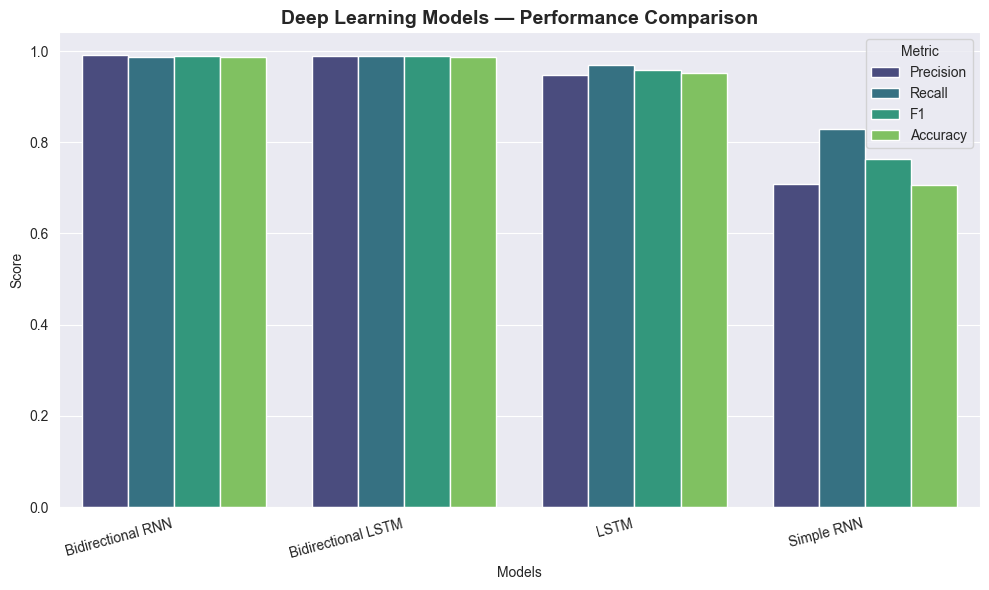

In [78]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_melt_deep.sort_values(by="Score", ascending=False),
    x="Model",
    y="Score",
    hue="Metric",
    palette="viridis"
)
plt.title("Deep Learning Models — Performance Comparison", fontsize=14, weight='bold')
plt.xticks(rotation=15, ha="right")
plt.ylabel("Score")
plt.xlabel("Models")
plt.tight_layout()
plt.show()